In [1]:
import os
from typing import Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Dense, Input

In [2]:
NUM_INPUTS = 96
NUM_OUTPUTS = 1
VAL_SPLIT = 0.1  # Percentage
BATCH_SIZE = 64
EPOCHS = 100
PATIENCE = 10  # Early stoping
LEARNING_RATE = 1e-4

In [6]:
def make_dataset(df: pd.DataFrame, shuffle: bool = True) -> tf.data.Dataset:
    dataset = tf.data.Dataset.from_tensor_slices(df.to_numpy())
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(lambda window: (window[:NUM_INPUTS], window[NUM_INPUTS:]))
    dataset = dataset.batch(batch_size=BATCH_SIZE, drop_remainder=False).prefetch(3)

    return dataset


def get_compiled_model(
    input_shape: Sequence[int],
    num_outputs: int,
    hidden: Sequence[int] = (100, 100, 100),
    activation: str = "relu",
    lr: float = 1e-3,
    batch_norm: bool = False,
) -> keras.Model:
    model = tf.keras.Sequential()
    model.add(Input(shape=input_shape))
    if batch_norm:
        model.add(BatchNormalization())
    for h_units in hidden:
        model.add(Dense(h_units, activation="relu"))
    model.add(Dense(num_outputs))

    model.compile(
        optimizer=keras.optimizers.Adam(lr=lr),
        loss=keras.losses.mse,
        metrics=[keras.metrics.mse],
    )

    return model


def mse(a: np.array, b: np.array) -> float:
    return np.mean(np.square(a - b))


def mae(a: np.array, b: np.array) -> float:
    return np.mean(np.abs(a - b))


def smape(a: np.array, b: np.array) -> float:
    num = np.abs(b - a)
    den = np.abs(a) + np.abs(b)
    sum = np.where(den == 0, 0, num / den)
    return sum.mean()


def scale_dataframe(
    df: pd.DataFrame, cols: Sequence[str] = None, new_max: int = 1, new_min: int = -1
) -> None:
    cols = cols or df.columns
    info = {}
    for col in cols:
        col_max = df[col].max()
        col_min = df[col].min()
        df[col] = new_min + ((df[col] - col_min) * (new_max - new_min)) / (
            col_max - col_min
        )
        assert df[col].min() == new_min
        assert df[col].max() == new_max

        
        


def read_csv(path: str, scale: bool = False, **kwargs) -> pd.DataFrame:
    drop_cols = [f"y{i}" for i in range(NUM_OUTPUTS, 48)]  # drop unnecessary outputs
    drop_cols.append("Unnamed: 0")
    df = pd.read_csv(path)
    df.drop(columns=drop_cols, inplace=True)

    if scale:
        print(f"Scaling {path} . . .")
        input_cols = [f"x{i}" for i in range(96)]
        input_cols.append('y0')
        info = scale_dataframe(df, input_cols, **kwargs)

    return df

# Forecasting Unscaled Orignal Dataset

### Preparing dataset

In [7]:
df_train = read_csv("data/amarillo_norm_train.csv", scale=False)
df_test = read_csv("data/amarillo_norm_test.csv", scale=False)
targets = df_test["y0"].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

### Training

In [8]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 3220.7236 - mean_squared_error: 3220.7236 - val_loss: 2523.3303 - val_mean_squared_error: 2523.3303
Epoch 2/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2397.3423 - mean_squared_error: 2397.3423 - val_loss: 2372.8291 - val_mean_squared_error: 2372.8291
Epoch 3/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2320.4744 - mean_squared_error: 2320.4744 - val_loss: 2258.9375 - val_mean_squared_error: 2258.9375
Epoch 4/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2300.1289 - mean_squared_error: 2300.1289 - val_loss: 2255.5603 - val_mean_squared_error: 2255.5603
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2270.9424 - mean_squared_error: 2270.9424 - val_loss: 2208.0032 - val_mean_squared_error: 2208.0032
Epoch 6/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2262.3894 - mean_squared_error: 

### Testing

In [9]:
preds = model.predict(ds_test)
preds = preds.T[0]
preds_unscaled = preds.copy()

In [10]:
print(f"MSE {mse(targets, preds)}")
print(f"MAE {mae(targets, preds)}")
print(f"SMAPE {smape(targets, preds)}")

MSE 1477.0449551786658
MAE 16.266032234051576
SMAPE 0.5722097183250733


In [11]:
target_level_1 = targets.reshape(10, 144)[0]
target_level_10 = targets.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

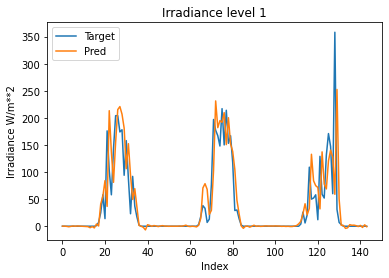

In [12]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

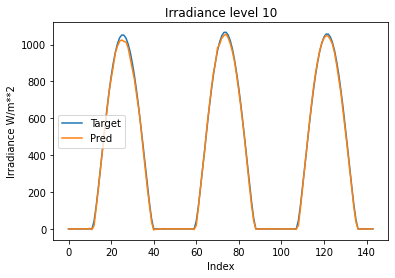

In [13]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Original Dataset
Scaled to -> \[0, 1]

### Preparing dataset

In [14]:
df_train = read_csv("data/amarillo_norm_train.csv", scale=True, new_min = 0, new_max = 1)
df_test_uscd = read_csv("data/amarillo_norm_test.csv", scale=False)
df_test = read_csv("data/amarillo_norm_test.csv", scale=True, new_min = 0, new_max = 1)
targets = df_test["y0"].values
test_min = df_test_uscd['y0'].min()
test_max = df_test_uscd['y0'].max()

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_norm_train.csv . . .
Scaling data/amarillo_norm_test.csv . . .


### Training

In [15]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoc

### Testing

In [16]:
preds = model.predict(ds_test)
df_test['pred'] = preds

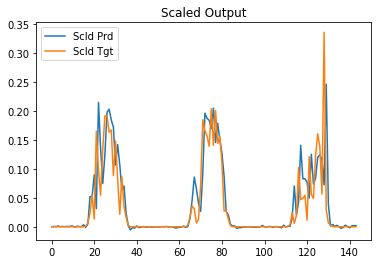

In [17]:
plt.plot(df_test['pred'][:48*3], label='Scld Prd')
plt.plot(df_test['y0'][:48*3], label='Scld Tgt')
plt.legend()
plt.title('Scaled Output')
plt.show()

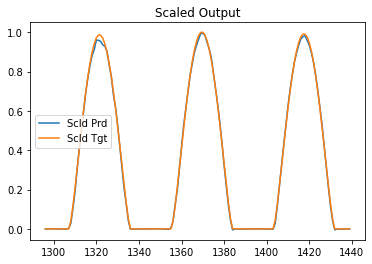

In [18]:
plt.plot(df_test['pred'][-48*3:], label='Scld Prd')
plt.plot(df_test['y0'][-48*3:], label='Scld Tgt')
plt.legend()
plt.title('Scaled Output')
plt.show()

In [19]:
scale_dataframe(df=df_test, cols=['y0', 'pred'], new_max=test_max, new_min=test_min)

In [20]:
targets = df_test['y0'].values
preds = df_test['pred'].values

In [21]:
print(f"MSE {mse(targets, preds)}")
print(f"MAE {mae(targets, preds)}")
print(f"SMAPE {smape(targets, preds)}")

MSE 1502.6553932286083
MAE 18.593865410404074
SMAPE 0.5680876283398205


<ipython-input-6-a7414efb5913>:47: RuntimeWarning: invalid value encountered in true_divide
  sum = np.where(den == 0, 0, num / den)


In [22]:
target_level_1 = targets.reshape(10, 144)[0]
target_level_10 = targets.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

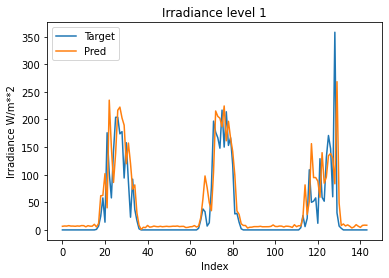

In [23]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

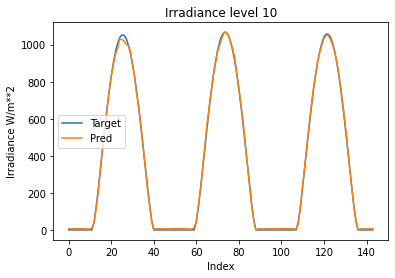

In [24]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Original Dataset
Scaled to -> \[-1, 1]

### Preparing dataset

In [25]:
df_train = read_csv("data/amarillo_norm_train.csv", scale=True, new_min = -1, new_max = 1)
df_test_uscd = read_csv("data/amarillo_norm_test.csv", scale=False)
df_test = read_csv("data/amarillo_norm_test.csv", scale=True, new_min = -1, new_max = 1)
targets = df_test["y0"].values
test_min = df_test_uscd['y0'].min()
test_max = df_test_uscd['y0'].max()

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_norm_train.csv . . .
Scaling data/amarillo_norm_test.csv . . .


### Training

In [26]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 2/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 3/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 4/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 6/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoc

### Testing

In [27]:
preds = model.predict(ds_test)
df_test['pred'] = preds

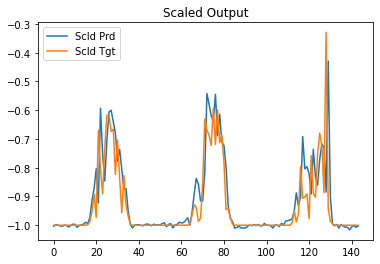

In [28]:
plt.plot(df_test['pred'][:48*3], label='Scld Prd')
plt.plot(df_test['y0'][:48*3], label='Scld Tgt')
plt.legend()
plt.title('Scaled Output')
plt.show()

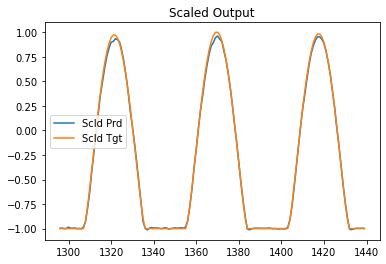

In [29]:
plt.plot(df_test['pred'][-48*3:], label='Scld Prd')
plt.plot(df_test['y0'][-48*3:], label='Scld Tgt')
plt.legend()
plt.title('Scaled Output')
plt.show()

In [30]:
scale_dataframe(df=df_test, cols=['y0', 'pred'], new_max=test_max, new_min=test_min)

In [31]:
targets = df_test['y0'].values
preds = df_test['pred'].values

In [32]:
print(f"MSE {mse(targets, preds)}")
print(f"MAE {mae(targets, preds)}")
print(f"SMAPE {smape(targets, preds)}")

MSE 1722.3786916564432
MAE 23.514253268639248
SMAPE 0.575146812480599


<ipython-input-6-a7414efb5913>:47: RuntimeWarning: invalid value encountered in true_divide
  sum = np.where(den == 0, 0, num / den)


In [33]:
target_level_1 = targets.reshape(10, 144)[0]
target_level_10 = targets.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

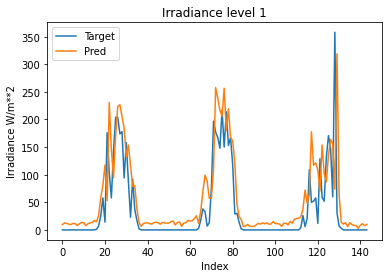

In [34]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

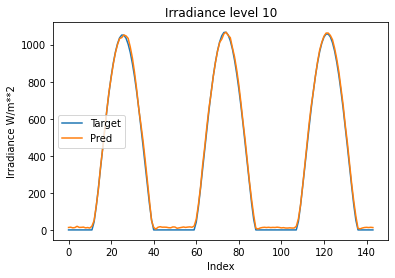

In [35]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Unscaled Differences Dataset

### Preparing dataset

In [36]:
df_train = read_csv("data/amarillo_diff_train.csv", scale=False)
df_test = read_csv("data/amarillo_diff_test.csv", scale=False)
df_orig_test = read_csv("data/amarillo_norm_test.csv", scale=False)
df_sky = read_csv("data/amarillo_sky_test.csv")
targets = df_test["y0"].values
targets_orig = df_orig_test['y0'].values
sky = df_sky['y0'].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

### Training

In [45]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100, 100, 100, 100),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2658.7537 - mean_squared_error: 2658.7537 - val_loss: 2450.3862 - val_mean_squared_error: 2450.3862
Epoch 2/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2344.1118 - mean_squared_error: 2344.1118 - val_loss: 2361.2019 - val_mean_squared_error: 2361.2019
Epoch 3/100
5155/5155 [==============================] - 13s 2ms/step - loss: 2293.4963 - mean_squared_error: 2293.4963 - val_loss: 2339.7605 - val_mean_squared_error: 2339.7605
Epoch 4/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2262.0684 - mean_squared_error: 2262.0684 - val_loss: 2342.7627 - val_mean_squared_error: 2342.7627
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2240.7058 - mean_squared_error: 2240.7058 - val_loss: 2316.9265 - val_mean_squared_error: 2316.9265
Epoch 6/100
5155/5155 [==============================] - 12s 2ms/step - loss: 2220.7708 - mean_squared_error: 

### Testing

In [46]:
preds_temp = model.predict(ds_test)
preds = sky - preds_temp.T[0]
preds_diff_unscaled = preds.copy()

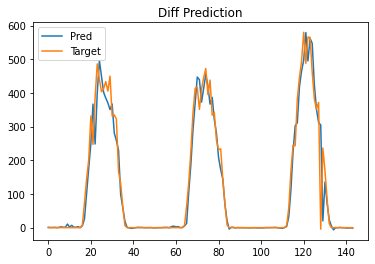

In [47]:
plt.plot(preds_temp[0:48*3], label='Pred')
plt.plot(targets[0:48*3], label='Target')
plt.title('Diff Prediction')
plt.legend()

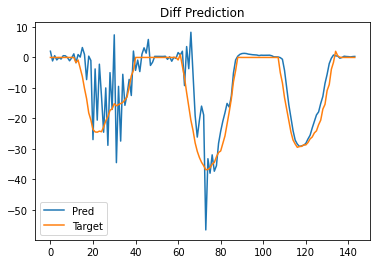

In [48]:
plt.plot(preds_temp[-48*3:], label='Pred')
plt.plot(targets[-48*3:], label='Target')
plt.title('Diff Prediction')
plt.legend()

In [49]:
print(f"MSE {mse(targets_orig, preds)}")
print(f"MAE {mae(targets_orig, preds)}")
print(f"SMAPE {smape(targets_orig, preds)}")

MSE 1550.3363468185514
MAE 16.10364512637143
SMAPE 0.5722986669256859


In [57]:
mod_preds = preds[:]
mod_preds[mod_preds<0] = 0

array([0., 0., 0., ..., 0., 0., 0.])

In [59]:
print(f"MSE {mse(targets_orig, mod_preds)}")
print(f"MAE {mae(targets_orig, mod_preds)}")
print(f"SMAPE {smape(targets_orig, mod_preds)}")

MSE 1542.035156551456
MAE 15.54076869880092
SMAPE 0.233409778036797


<ipython-input-6-a7414efb5913>:47: RuntimeWarning: invalid value encountered in true_divide
  sum = np.where(den == 0, 0, num / den)


In [50]:
target_level_1 = targets_orig.reshape(10, 144)[0]
target_level_10 = targets_orig.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

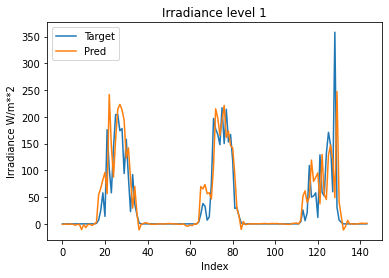

In [51]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

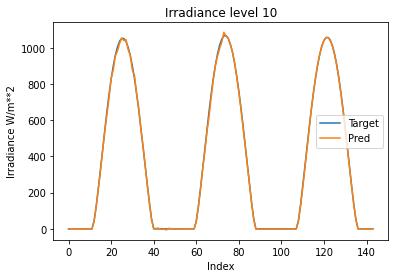

In [52]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Differences Dataset
Scaled -> [0, 1]

### Preparing dataset

In [67]:
df_train = read_csv("data/amarillo_diff_train.csv", scale=True, new_min = 0, new_max = 1)
df_test = read_csv("data/amarillo_diff_test.csv", scale=True, new_min = 0, new_max = 1)
df_orig_test = read_csv("data/amarillo_norm_test.csv", scale=False)
df_sky = read_csv("data/amarillo_sky_test.csv")
targets = df_test["y0"].values
targets_orig = df_orig_test['y0'].values
sky = df_sky['y0'].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_diff_train.csv . . .
Scaling data/amarillo_diff_test.csv . . .


In [68]:
df_train['x0'].max()

1.0

In [69]:
df_train['x0'].min()

0.0

### Training

In [70]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

5155/5155 [==============================] - 12s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0031 - val_mean_squared_error: 0.0031


### Testing

In [71]:
preds_temp = model.predict(ds_test)
preds = sky - preds_temp.T[0]
preds_diff_unscaled = preds.copy()

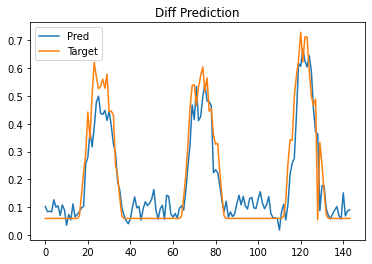

In [72]:
plt.plot(preds_temp[0:48*3], label='Pred')
plt.plot(targets[0:48*3], label='Target')
plt.title('Diff Prediction')
plt.legend()

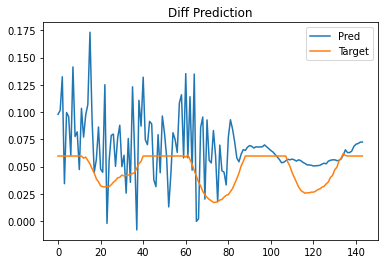

In [73]:
plt.plot(preds_temp[-48*3:], label='Pred')
plt.plot(targets[-48*3:], label='Target')
plt.title('Diff Prediction')
plt.legend()

In [74]:
print(f"MSE {mse(targets_orig, preds)}")
print(f"MAE {mae(targets_orig, preds)}")
print(f"SMAPE {smape(targets_orig, preds)}")

MSE 19196.67497984341
MAE 56.53657485019481
num=array([0.1027515 , 0.08397934, 0.08539937, ..., 0.07114024, 0.07240593,
       0.07254487])
den=array([0.1027515 , 0.08397934, 0.08539937, ..., 0.07114024, 0.07240593,
       0.07254487])
sum=array([1., 1., 1., ..., 1., 1., 1.])
SMAPE 0.6150021836526028


In [75]:
target_level_1 = targets_orig.reshape(10, 144)[0]
target_level_10 = targets_orig.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

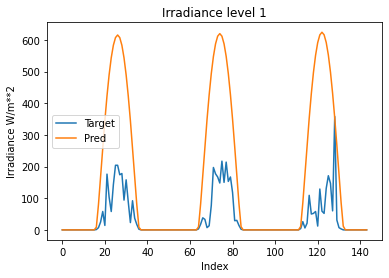

In [76]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

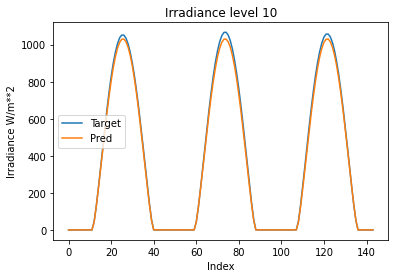

In [77]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Forecasting Scaled Differences Dataset
Scaled -> [-1, 1]

### Preparing dataset

In [60]:
df_train = read_csv("data/amarillo_diff_train.csv", scale=True, new_min = -1, new_max = 1)
df_test = read_csv("data/amarillo_diff_test.csv", scale=True, new_min = -1, new_max = 1)
df_orig_test = read_csv("data/amarillo_norm_test.csv", scale=False)
df_sky = read_csv("data/amarillo_sky_test.csv")
targets = df_test["y0"].values
targets_orig = df_orig_test['y0'].values
sky = df_sky['y0'].values

# Validation
len_val = int(VAL_SPLIT * len(df_train))
val_ind = df_train.sample(len_val).index.values
df_val = df_train.iloc[val_ind]
df_train.drop(labels=val_ind, inplace=True)

# Make datasets
ds_train = make_dataset(df_train)
ds_val = make_dataset(df_val)
ds_test = make_dataset(df_test, shuffle=False)

Scaling data/amarillo_diff_train.csv . . .
Scaling data/amarillo_diff_test.csv . . .


### Training

In [61]:
model = get_compiled_model(
    input_shape=(NUM_INPUTS,),
    hidden=(100, 100, 100,),
    num_outputs=NUM_OUTPUTS,
    lr=LEARNING_RATE,
)
model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=PATIENCE, restore_best_weights=True
        )
    ],
)

Epoch 1/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 2/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 3/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 4/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 5/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 6/100
5155/5155 [==============================] - 12s 2ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoc

### Testing

In [62]:
preds_temp = model.predict(ds_test)
preds = sky - preds_temp.T[0]
preds_diff_unscaled = preds.copy()

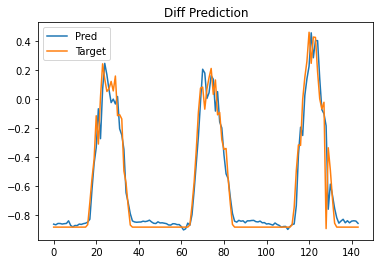

In [63]:
plt.plot(preds_temp[0:48*3], label='Pred')
plt.plot(targets[0:48*3], label='Target')
plt.title('Diff Prediction')
plt.legend()

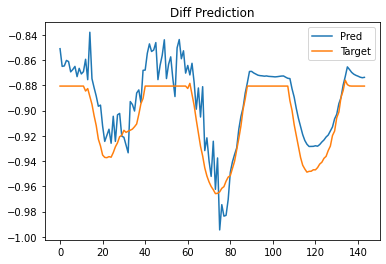

In [64]:
plt.plot(preds_temp[-48*3:], label='Pred')
plt.plot(targets[-48*3:], label='Target')
plt.title('Diff Prediction')
plt.legend()

In [66]:
print(f"MSE {mse(targets_orig, preds)}")
print(f"MAE {mae(targets_orig, preds)}")
print(f"SMAPE {smape(targets_orig, preds)}")

MSE 19242.3385970612
MAE 56.976809465513654
SMAPE 0.6150636241461688


In [67]:
target_level_1 = targets_orig.reshape(10, 144)[0]
target_level_10 = targets_orig.reshape(10, 144)[9]
pred_level_1 = preds.reshape(10, 144)[0]
pred_level_10 = preds.reshape(10, 144)[9]

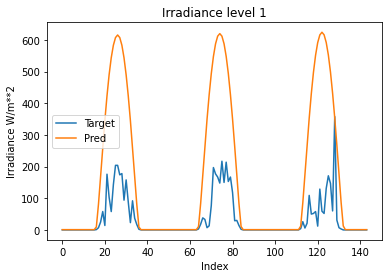

In [68]:
plt.plot(target_level_1, label='Target')
plt.plot(pred_level_1, label='Pred')
plt.title('Irradiance level 1')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

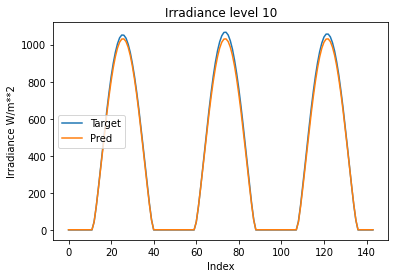

In [69]:
plt.plot(target_level_10, label='Target')
plt.plot(pred_level_10, label='Pred')
plt.title('Irradiance level 10')
plt.xlabel('Index')
plt.ylabel('Irradiance W/m**2')
plt.legend()
plt.show()

# Summary

In [54]:
print('Original Unscaled')
print(f"MSE {mse(targets, preds_unscaled)}")
print(f"MAE {mae(targets, preds_unscaled)}")
print(f"SMAPE {smape(targets, preds_unscaled)}")

Original Unscaled
MSE 74559.49801041631
MAE 149.61019791300194
SMAPE 0.8676888786767888


In [55]:
print('Original Scaled (0, 1)')
print(f"MSE {mse(targets, preds_scaled)}")
print(f"MAE {mae(targets, preds_scaled)}")
print(f"SMAPE {smape(targets, preds_scaled)}")

Original Scaled (0, 1)
MSE 75817.29209521071
MAE 151.36938054263203
SMAPE 0.8693709533191782


In [56]:
print('Original Scaled (-1, 1)')
print(f"MSE {mse(targets, preds_scaled_neg)}")
print(f"MAE {mae(targets, preds_scaled_neg)}")
print(f"SMAPE {smape(targets, preds_scaled_neg)}")

Original Scaled (-1, 1)
MSE 74979.40371993928
MAE 149.19719384872067
SMAPE 0.8688484356230695


In [57]:
print('Differences Unscaled')
print(f"MSE {mse(targets_orig, preds_diff_unscaled)}")
print(f"MAE {mae(targets_orig, preds_diff_unscaled)}")
print(f"SMAPE {smape(targets_orig, preds_diff_unscaled)}")

Differences Unscaled
MSE 1870.0894034898206
MAE 17.935002996370464
SMAPE 0.5781861089431134


In [58]:
print('Differences Scaled (0, 1)')
print(f"MSE {mse(targets_orig, preds_diff_scaled)}")
print(f"MAE {mae(targets_orig, preds_diff_scaled)}")
print(f"SMAPE {smape(targets_orig, preds_diff_scaled)}")

Differences Scaled (0, 1)
MSE 3614.424223858286
MAE 31.822405659789542
SMAPE 0.617983432390896


In [59]:
print('Differences Scaled (-1, 1)')
print(f"MSE {mse(targets_orig, preds_diff_scaled_neg)}")
print(f"MAE {mae(targets_orig, preds_diff_scaled_neg)}")
print(f"SMAPE {smape(targets_orig, preds_diff_scaled_neg)}")

Differences Scaled (-1, 1)
MSE 3473.368577092031
MAE 32.837405033836106
SMAPE 0.6163393960732045
